In [2]:
import pandas as pd

Set seed value

In [3]:
seed_value = 56

### Load Carlifornia District's House Value Regression dataset
#### Description of the features can be found here: https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset

In [4]:
from sklearn.datasets import fetch_california_housing as carl_house

In [5]:
carl = carl_house()

In [6]:
X = pd.DataFrame(carl.data, columns=carl.feature_names)
y = pd.DataFrame(carl.target, columns=['District_hvalue'])

In [7]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [8]:
y.head()

,District_hvalue
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422


In [9]:
#Produce feature stats, such as min, max, mean etc
X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [10]:
y.describe()

,District_hvalue
count,20640.000000
mean,2.068558
std,1.153956
min,0.149990
25%,1.196000
50%,1.797000
75%,2.647250
max,5.000010


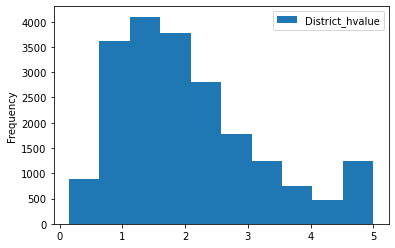

In [12]:
#Check if dataset is balanced
# Data is skewed to the left i.e. majority of districts in carlifornia have low housing value between 50,000$ and 250,000$
y.plot.hist()

### Data Modelling

In [13]:
from sklearn.model_selection import train_test_split

#split data into training and test sets

#test set size
data_size_for_testing = 0.3

x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=data_size_for_testing, 
                                                    random_state=seed_value,  shuffle=True
                                                   )


In [14]:
#Features are standardised to improve model training and target labels transformed to integer classes.  
from sklearn.preprocessing import StandardScaler, LabelEncoder
standscaler = StandardScaler()

#We standardise the training set and use the standardised object to transform the test set to ensure consistency between training and test sets
standscaler.fit(x_train)

#training
train_features = pd.DataFrame(standscaler.transform(x_train), columns=x_train.columns)
x_train = train_features
y_train = y_train.reset_index().drop("index", axis=1)

#test
test_features = pd.DataFrame(standscaler.transform(x_test), columns=x_test.columns)
x_test= test_features
y_test = y_test.reset_index().drop("index", axis=1)





### Training Stage

In [16]:
#train a random forest model
from sklearn.ensemble import RandomForestRegressor
model_rgr = RandomForestRegressor(random_state=seed_value)
model_rgr.fit(x_train,y_train.values.ravel())


RandomForestRegressor(random_state=56)

### Evaluate Model Performance
#### Using R-squared

In [17]:
from sklearn.metrics import mean_squared_error,r2_score

In [18]:
y_val = model_rgr.predict(x_test)

In [19]:
#Performance report
print('MSE:' + str(mean_squared_error(y_test,y_val)))
print('R-Squared:' + str(r2_score(y_test,y_val)))

MSE:0.26713547225094914
R-Squared:0.8025152258499579


### Permutation Importance

In [20]:
import copy
import numpy as np

# Set numpy pseudo-random generator at a fixed value
np.random.seed(seed_value)

def PI_calculate(model, data, criterion):
    PI_matrix = []
    original_pred = model.predict(data[0])
    original_error = criterion(data[1],original_pred)
    for feature in range(data[0].shape[1]):
        perbutated_data= copy.deepcopy(data[0])
        np.random.shuffle(perbutated_data.iloc[ : , feature])
        perbutated_pred = model.predict(perbutated_data)
        perbutated_error = criterion(data[1], perbutated_pred)
        PI_matrix.append((original_error - perbutated_error))
    return pd.DataFrame(PI_matrix, index=data[0].columns, columns=['Features']).transpose()


In [21]:
PI = PI_calculate(model_rgr,[x_test,y_test],r2_score)

### Plot feature importance 

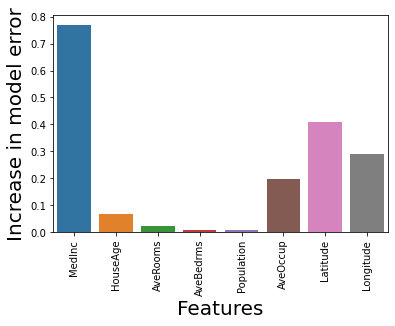

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
p = sns.barplot(x = PI.columns,y=PI.values.flatten())
p.set_xlabel("Features", fontsize = 20)
p.set_ylabel("Increase in model error", fontsize = 20)
p.set_xticklabels(p.get_xticklabels(),rotation = 90)
plt.plot()
plt.savefig('Carlifornia_house_PI.png',bbox_inches = "tight")